# 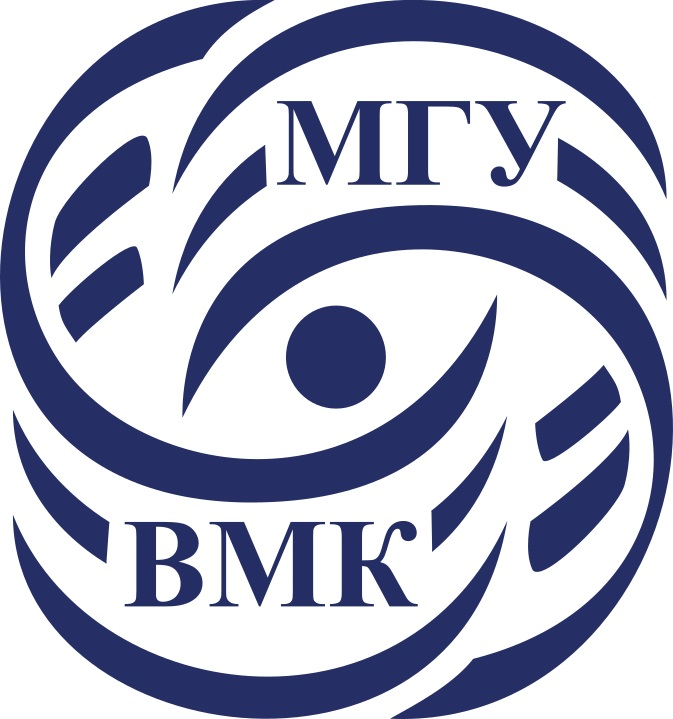

# Машинное обучение. ВМК МГУ

# Практическое задание 8: Деревья решений
## Уровень: <font color='SkyBlue'>**Базовый (Base)**</font>

# О формате сдачи

🔷 **<font color='plum'>При решении ноутбука используйте данный шаблон</font>**

    ✅ Можно добавлять новые ячейки любых типов
    ❌ Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий


🔷 **<font color='plum'>При оценивании задач учитывается код</font>**

    ✅ Задания, в которых необходим код, обычно помечаются фразами "Your code here"/"Ваш код" и аналогичными
    ❌ Ответы на вопросы без сопутствующего кода оцениваются в 0 баллов
    ❌ Наличе работоспособного кода в ноутбуке, если на сказано иного, обязательно

🔷 **<font color='plum'>При оценивании задач учитываются выводы</font>**

    ✅ Задания, в которых необходимы выводы, обычно помечаются фразами Вывод"/"Ответ на вопрос"/"Ваш текст" и аналогичными
    ✅ Обычно выводы подразумевают под собой текстовый ответ (можно писать markdown, latex).
    ✅ Сопутствующие изображения, графики, таблички - приветствуются!
    ❌ При отсутствии выводов задание не засчитается на полный балл

__В этом задании вы:__

- Посмотрите глазами, как же работают деревья решений.
- Реализуете различные меры качества разбиения в вершине.
- Визуализируете работу дерева решений
- Изучите, как получить из обученного дерева важность признаков.

-------
<font color="white" style="opacity:0.2024"></font>
<font color=DarkOrange>**Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: до 10 минут </font>**

# Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

<font color='OrangeRed'>**Важно!**</font>

Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

<font color='OrangeRed'>**Важно!**</font>
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-24-25/blob/main/tutorials/%D0%A2%D1%83%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%20%D0%BF%D0%BE%20%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B5%20%D1%80%D0%B0%D0%B1%D0%BE%D1%87%D0%B5%D0%B3%D0%BE%20%D0%BE%D0%BA%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B2%20Python%20%D0%B4%D0%BB%D1%8F%20%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%20(2).pdf)


In [1]:
# !!! Данный блок будет работать только в Google-Colab !!!
! gdown 10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
! pip install -r /content/requirements_2024_25_for_colab_small.txt

Downloading...
From: https://drive.google.com/uc?id=10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
To: /content/requirements_2024_25_for_colab_small.txt
100% 375/375 [00:00<00:00, 1.93MB/s]


Проверим версию библиотеки:

In [2]:
import catboost
assert(catboost.__version__ == '1.2.7')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2023"></font>

Привет, ребятушки!

Сегодня мы с вами посмотрим на такую вещь, как деревья решений. Мы попытаемся понять принцип их работы, пощупать, исследовать влияние параметров и, самое главное, узнаем, какое свойство случайных лесов оказало сильное влияние на машинное обучение.

Хочу обратить внимание, что в этом задании мы будем работать с регрессорами, однако все сделанные нами выводы верны также и для задач классификации.

<font color='OrangeRed'>**Внимание!**</font> Во всех заданиях в качестве целевой метрики используется MAE (средняя абсолютная ошибка). Значение MAE вычисляется как

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

Для вычисления MAE можно использовать встроенную функцию `sklearn.metrics.mean_absolute_error`

Импортируем необходимые библиотеки:

In [3]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline # Если забыли, загляните в ноутбук Sklearn-knn-normalize-cv
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV

import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

#####
# если Вы не различаете предлагаемые цвета, то Вы можете раскомментить строку ниже
# для применения специальной цветовой палитры или аналогичных
# plt.style.use('tableau-colorblind10')
#####

import numpy as np

import time
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Задание для проверяющей системы


## <font color='DarkOrange'>**Задание 0 (unit-тесты)**</font>

Как Вы знаете из лекций, решающие деревья на каждом шаге разбивают множество объектов на два подмножества, выбирая такой критерий, по которому разбиение наиболее оптимальное. В качестве меры качества таких разбиений для **задачи классификации** могут выступать три меры (наиболее популярные):

1) `Gini`

2) `Entropy`

3) `Classification Error`.


Вам нужно реализовать все три меры качества и загрузить их реализацию в тестирующую систему cv-gml.ru

Подробнее об этом задании вы можете прочитать в соответствующем .pdf файле.

# Обучение дерева решения и визуализация

На лекции вам рассказывали, что деревья решений несколько раз дробят выборки, используя какие-то значения
признаков, и таким образом строят цепочки условий для принятия решения. Давайте убедимся в этом лично.

Загрузим датасет со стоимостью недвижимости в Калифорнии, который нам понадобится для первых заданий:

In [4]:
def get_california_dataset():
    """Return the splits of the California housing dataset for training and testing"""
    X, y = fetch_california_housing(return_X_y=True)
    return train_test_split(X, y, random_state=42)

X_train, X_test, y_train, y_test = get_california_dataset()

## <font color='DarkOrange'>**Задание 1 [1.5 баллa]**</font>

**Данные**: датасет со стоимостью недвижимости в Калифорнии  
**Цели**: В данном задании следует выполнить следующие пункты:

1. <font color='DarkOrange'>**[0.5 балл]**</font> Обучите ``DecisionTreeRegressor`` на обучающей выборке, установив ``random_state=0``. Здесь мы принудительно ограничиваем максимальную глубину дерева до 3, чтобы получившаяся визуализация не была слишком большой.
1. <font color='DarkOrange'>**[0.5 балл]**</font> При помощи функции `sklearn.tree.plot_tree` визуализируйте получившееся дерево.


<font color='LightSteelBlue'>**Подсказка**</font> Можете передать `fetch_california_housing().feature_names` для улучшения визуализации. Для того чтобы визуализация выглядела лучше, можете воспользоваться аргументом `fontsize`, а также установить  ``plt.figure(figsize=(X,Y))``.

1. <font color='DarkOrange'>**[0.5 балл]**</font> Возьмите любой объект из тестовой выборки. Предскажите его цену при помощи функции `.predict` обученного регрессора, а затем, воспользовавшись полученной визуализацией, опишите правила, по которым дерево сделало свой вывод. Опишите словами эти решения ниже.

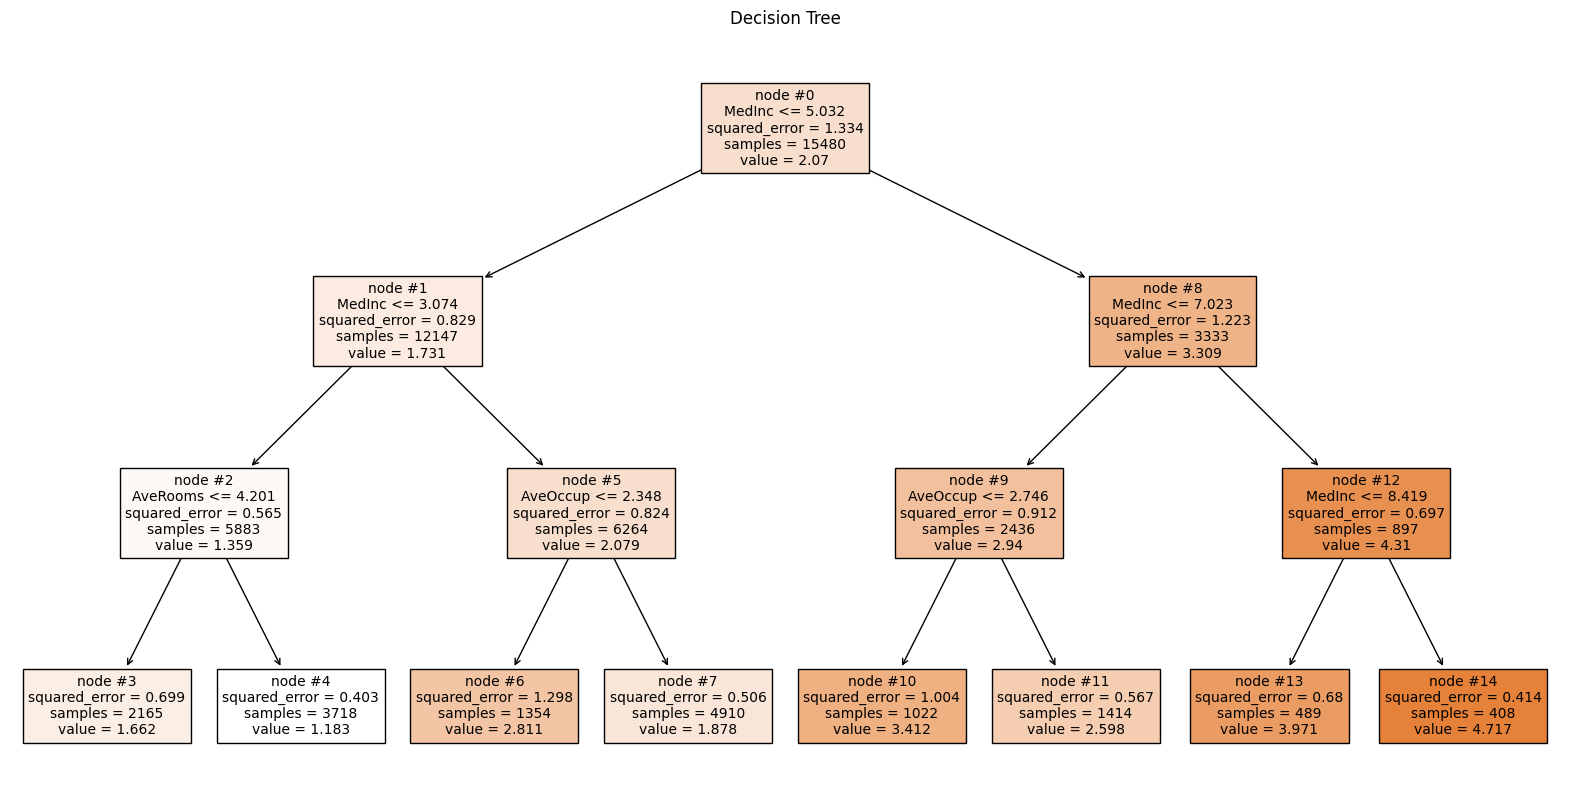

In [40]:
decision_tree_regressor = DecisionTreeRegressor(max_depth=3, random_state=0)
decision_tree_regressor.fit(X_train, y_train)

feature_names = fetch_california_housing().feature_names

plt.figure(figsize=(20, 10))
plot_tree(decision_tree_regressor, filled=True, feature_names=feature_names, fontsize=10, node_ids=True)
plt.title("Decision Tree")
plt.show()

In [34]:
import random

random.seed(42)
sample_index = random.randint(0, len(X_test) - 1)

print(f"Predicted target: {decision_tree_regressor.predict(X_test[sample_index].reshape(1, -1))[0] * 100_000:.2f}")
print(f"Real target: {y_test[sample_index] * 100_000:.2f}\n")

print("Features:")
for feature, value in zip(feature_names, X_test[sample_index]):
    print(f"{feature}: {value:.2f}")

Predicted target: 118256.16
Real target: 132700.00

Features:
MedInc: 1.93
HouseAge: 44.00
AveRooms: 6.88
AveBedrms: 1.59
Population: 1112.00
AveOccup: 2.37
Latitude: 38.50
Longitude: -122.97


<font color='MediumOrchid'>**Ваш ответ тут:**</font>

**#0 -> #1 -> #2 -> #4**

Первое решающее правило: MedInc <= 5.032<br>
Для нашего объекта: 1.93 < 5.032<br>
Переходим в левый дочерний узел #1<br>

Второе решающее правило: MedInc <= 3.074<br>
Для нашего объекта: 1.93 < 3.074<br>
Переходим в левый дочерний узел #2<br>

Третье решающее правило: AveRooms <= 4.201<br>
Для нашего объекта: 6.88 > 4.201<br>
Переходим в правый дочерний узел #4, который является терминальным<br>
Получаем предсказание 118256.16<br>
Истинное значение для этого объекта равно 132700.00

# Переобучение дерева

Дерево решений склонно к переобучению, потому что оно может слишком точно подстраиваться под данные, на которых его обучают. Когда дерево принимает решения, оно делит данные на множество мелких групп, чтобы максимально точно определить каждую категорию. Это может привести к тому, что дерево запоминает даже случайные особенности и шум в данных, а не выявляет общие закономерности. В результате, когда мы пытаемся использовать такое дерево на новых данных, оно может работать плохо, потому что не может обобщить свои выводы.


## <font color='DarkOrange'>**Задание 2 [2 баллa]**</font>

Проверим в этом задании, при каких условиях дерево переобучается и как это можно отловить на практике.
Будем исследовать зависимость наличия переобучения дерева от его глубины.

Для этого воспользуемся техникой кросс-валидации


Обучите `GridSearchCV` для нашей модели регрессионного дерева. Переберите максимальную глубину от 1 до 30 включительно с шагом 1.

In [35]:
model = DecisionTreeRegressor(random_state=0)
parameters = {'max_depth': range(1, 31)}

cv = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error', return_train_score=True, verbose=1)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': range(1, 31)}, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

Также обучим для каждой глубины свое дерево и посчитаем метрику качества на тестовой выборке:

In [36]:
maes = []
for m in parameters['max_depth']:
    model = DecisionTreeRegressor(max_depth=m)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    maes.append(mean_absolute_error(y_pred, y_test))

Посмотрим на результаты кросс-валидации:

In [37]:
res = cv.cv_results_
res['mean_final_test_score'] = maes
res['mean_train_score'] = -res['mean_train_score'] # минус, так как по канону sklearn оптимизируемый функционал нужно максимизировать
# и в результатах лежит отрицательный MAE
res['mean_test_score'] = -res['mean_test_score'] # на самом деле валидация

In [38]:
df = pd.DataFrame(res)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,mean_final_test_score
0,0.013914,0.004452,0.001122,0.000163,1,{'max_depth': 1},-0.752062,-0.727155,-0.746262,-0.744973,...,0.008752,30,-0.738800,-0.746721,-0.740599,-0.742620,-0.739104,0.741569,0.002910,0.752402
1,0.024807,0.004517,0.000953,0.000121,2,{'max_depth': 2},-0.663754,-0.640262,-0.663163,-0.652011,...,0.008627,29,-0.647597,-0.655251,-0.649388,-0.651790,-0.650602,0.650926,0.002569,0.661383
2,0.034674,0.002711,0.001101,0.000061,3,{'max_depth': 3},-0.607718,-0.578278,-0.603793,-0.597519,...,0.010118,28,-0.582691,-0.591196,-0.594001,-0.590132,-0.584884,0.588581,0.004171,0.600190
3,0.116889,0.040262,0.003781,0.004984,4,{'max_depth': 4},-0.567531,-0.541596,-0.551708,-0.560562,...,0.009028,27,-0.544834,-0.550582,-0.544567,-0.548081,-0.541499,0.545913,0.003129,0.556729
4,0.156588,0.030535,0.003063,0.002707,5,{'max_depth': 5},-0.535188,-0.513607,-0.516861,-0.535777,...,0.009328,26,-0.510151,-0.515810,-0.500819,-0.515572,-0.507889,0.510048,0.005542,0.529424
5,0.118322,0.057233,0.001205,0.000114,6,{'max_depth': 6},-0.511098,-0.489039,-0.485077,-0.505497,...,0.009963,25,-0.473074,-0.477274,-0.453298,-0.478331,-0.474251,0.471246,0.009177,0.499462
6,0.163292,0.066492,0.003870,0.005215,7,{'max_depth': 7},-0.484444,-0.461670,-0.453284,-0.475928,...,0.011279,13,-0.435688,-0.433538,-0.414744,-0.438517,-0.438952,0.432288,0.008990,0.477555
7,0.094169,0.016073,0.001307,0.000091,8,{'max_depth': 8},-0.467885,-0.438240,-0.428093,-0.455029,...,0.013698,6,-0.392710,-0.388694,-0.372984,-0.396171,-0.393550,0.388822,0.008275,0.452202
8,0.111866,0.052760,0.002664,0.003205,9,{'max_depth': 9},-0.460956,-0.426682,-0.418329,-0.445033,...,0.014841,4,-0.351305,-0.348829,-0.333553,-0.356435,-0.352757,0.348576,0.007905,0.434363
9,0.077482,0.001806,0.001034,0.000057,10,{'max_depth': 10},-0.450465,-0.423896,-0.418171,-0.442253,...,0.011802,1,-0.309321,-0.307004,-0.297344,-0.315841,-0.309637,0.307829,0.006005,0.431816


Отобразим их:

In [39]:
fig = px.line(df, x='param_max_depth', y=["mean_train_score", "mean_test_score", "mean_final_test_score"])
fig.update_layout(xaxis_title='Максимальная глубина дерева', yaxis_title='MAE')

## <font color='DarkOrange'>**Задание 3 [1 балл]**</font>

Сделайте следующие выводы исходя из графика

1) Наблюдается ли переобучение? Если да, то по каким признакам на графике вы это поняли?

2) Как ведет себя качество на валидации и на тестовой выборке? Ожидаемое ли это поведение?

3) Какую бы глубину дерева вы взяли как оптимальную для данной задачи?

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

1) **Да.** С ростом максимальной глубины дерева **ошибка уменьшается на тренировочном** наборе данных, но начинает немного **увеличиваться на тестовом** наборе данных, начиная с глубины 10

2) На валидационной и тестовой выборках качество **изначально улучшается**, так как первоначально дерево сильно обрезано и недостаточно репрезентативно. Затем качество **начинает ухудшаться,** поскольку дерево становится все более переобученным. Такое поведение **ожидаемо**

3) **10.** По причинам из предыдущих пунктов

# Масштабирование признаков

Деревья решений не требуют масштабирования данных, потому что они работают по принципу деления данных на группы на основе значений признаков. Они принимают решения, сравнивая значения и выбирая, в какую ветвь дерева направить данные. Поскольку деревья решений основаны на относительных значениях и порогах, а не на расстоянии между точками, их работа не зависит от масштаба признаков. В отличие от этого, линейные модели, такие как линейная регрессия, чувствительны к масштабам признаков, потому что они рассчитывают расстояния и углы между точками, и если признаки имеют разные масштабы, это может исказить результаты. Поэтому деревьям решений не нужно предварительное масштабирование данных, что упрощает процесс подготовки данных.

## <font color='DarkOrange'>**Задание 4 [2 баллa]**</font>

Сравним качество дерева решений с линейной регрессий с и без масштабирования

Обучите <font color='DarkOrange'>**[1 балл]**</font>:

1) Дерево решений глубины 10 без масштабирования признаков

2) Дерево решений глубины 10 с масштабированием признаков

3) Линейную регрессию ([RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) для поиска оптимального alpha)  без масштабирования признаков (MinMaxScaler)

4) Линейную регрессию (RidgeCV для поиска оптимального alpha) с масштабированием признаков  (MinMaxScaler)

<font color='DarkOrange'>**[1 балл]**</font> Сравните их между собой и сделайте выводы:

1) Есть ли разница в качестве на тестовой выборке для дерева решения в зависимости от масштабирования признаков?

2) Есть ли разница в качестве на тестовой выборке для линейной регрессии в зависимости от масштабирования признаков?

3) Какая модель показала лучшее качество? Как вы думаете, почему?

In [64]:
tree = DecisionTreeRegressor(max_depth=10, random_state=0)
tree.fit(X_train, y_train)

tree_normalized = Pipeline([
    ('scaler', MinMaxScaler()),
    ('tree', DecisionTreeRegressor(max_depth=10, random_state=0))
])
tree_normalized.fit(X_train, y_train)

ridge = RidgeCV()
ridge.fit(X_train, y_train)

ridge_normalized = Pipeline([
    ('scaler', MinMaxScaler()),
    ('ridge', RidgeCV())
])
ridge_normalized.fit(X_train, y_train)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return mean_absolute_error(y_test, y_pred)

In [66]:
mae_tree = evaluate_model(tree, X_test, y_test)
mae_tree_normalized = evaluate_model(tree_normalized, X_test, y_test)
mae_ridge = evaluate_model(ridge, X_test, y_test)
mae_ridge_normalized = evaluate_model(ridge_normalized, X_test, y_test)

print(f"MAE of decision tree without scaling: {mae_tree:.4f}")
print(f"MAE of decision tree with scaling: {mae_tree_normalized:.4f}")
print(f"MAE of RidgeCV without scaling: {mae_ridge:.4f}")
print(f"MAE of RidgeCV with scaling: {mae_ridge_normalized:.4f}")

MAE of decision tree without scaling: 0.4311
MAE of decision tree with scaling: 0.4318
MAE of RidgeCV without scaling: 0.5297
MAE of RidgeCV with scaling: 0.5306


<font color='MediumOrchid'>**Ваши выводы тут:**</font>

1) Разница в качестве между деревом решений с масштабированием и без него очень **мала**

2) Разница в качестве линейной регрессии с масштабированием и без него также очень **мала**<br>

3) **Дерево без масштабирования.** Поскольку оно способно подстраиваться под **нелинейные зависимости**



# Важность признаков

Деревья решений оценивают важность признаков, анализируя, насколько каждый признак помогает разделить данные на разные категории. Когда дерево принимает решение, оно выбирает признак, который лучше всего разделяет данные на группы. Если признак позволяет сделать более четкое разделение, он получает высокую оценку важности. Например, если признак "возраст" помогает точно разделить людей на группы "молодые" и "пожилые", значит, он будет считаться важным. В итоге деревья решений могут подсказывать, какие признаки наиболее влиятельны в процессе принятия решений

## <font color='DarkOrange'>**Задание 5 [0.5 балл]**</font>

Изучим, какие признаки оказались наиболее важными в нашей задаче

Снова обучите дерево решений глубины 10 и с помощью аттрибута `feature_importances_` у модели выясните, какие признаки оказались наиболее важными, а какие - наименее. Совпадает ли это с вашими ожиданиями? Опишите это в выводах

<font color='LightSteelBlue'>**Подсказка**</font> Используйте `fetch_california_housing().feature_names` для получения названий признаков

In [52]:
model = DecisionTreeRegressor(max_depth=10, random_state=0)
model.fit(X_train, y_train)

feature_importances = pd.DataFrame(model.feature_importances_, index=fetch_california_housing().feature_names, columns=["Importance"])
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

print(feature_importances)

            Importance
MedInc        0.609726
AveOccup      0.137592
Latitude      0.071131
Longitude     0.065503
HouseAge      0.042429
AveRooms      0.036448
Population    0.021329
AveBedrms     0.015842


<font color='MediumOrchid'>**Ваши выводы тут:**</font>

**Наиболее важными признаками оказались MedInc и AveOccup.** Это ожидаемо, поскольку средний доход и количество жильцов сильно влияют на цену жилья

**Наименее важными: Population и AveBedrms.** Обычно население и количество спален влияют на стоимость жилья. Но в данном случае, возможно, что эти признаки уже учитываются косвенно через другие факторы, например, те же MedInc и AveOccup

Мы смогли убедиться, что дерево решений действительно строит систему правил, по которым предсказывает цену недвижимости. Также мы можем убедиться, что множество возможных предсказаний регрессора сильно ограничено: все они перечислены в листовых вершинах графа. Но в чем же тогда сила деревьев решений, брат? О том, как на практике используются деревья для построениях одних из самых мощных алгоритмов машинного обучения вы узнаете в следующих практических заданиях